# Analisis Exploratorio de Datos (EDA)
## Dataset: Predict Students' Dropout and Academic Success

Este notebook realiza un analisis exploratorio del dataset de prediccion de desercion estudiantil en educacion superior.

**Fuente:** [Kaggle - Higher Education Predictors of Student Retention](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention)

### Contenido:
1. Configuracion y Carga de Datos
2. Analisis Basico
3. Distribucion de Variables
4. Analisis de Variables Categoricas
5. Correlaciones
6. Analisis Bivariado (Variables vs Target)
7. Deteccion de Outliers
8. Resumen

## 1. Configuracion y Carga de Datos


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configuracion de visualizacion
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuracion de figuras
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [2]:
# ============================================================
# CONFIGURACION DE FUENTE DE DATOS
# ============================================================
# Cambiar esta variable para seleccionar la fuente de datos:
#   - "local": Carga desde ruta local (el archivo debe existir)
#   - "dvc": Ejecuta 'dvc pull' para descargar datos del remote S3
# ============================================================

DATA_SOURCE = "local"  # Opciones: "dvc" o "local"
LOCAL_PATH = "../data/dropout_students.csv"

def load_data():
    """
    Carga el dataset segun la configuracion DATA_SOURCE.
    
    Returns:
        pd.DataFrame: Dataset de estudiantes
    """
    if DATA_SOURCE == "dvc":
        print("Descargando datos desde DVC remote (S3)...")
        import subprocess
        import os
        
        # Cambiar al directorio raiz del proyecto para ejecutar dvc pull
        project_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
        result = subprocess.run(
            ["dvc", "pull"], 
            cwd=os.path.dirname(os.path.dirname(os.path.abspath(LOCAL_PATH))),
            capture_output=True, 
            text=True
        )
        
        if result.returncode != 0:
            print(f"Advertencia DVC: {result.stderr}")
        else:
            print("Datos descargados exitosamente desde DVC.")
        
        df = pd.read_csv(LOCAL_PATH, delimiter=',')
        print(f"Dataset cargado desde DVC: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df
    
    else:  # local
        print("Cargando datos desde ruta local...")
        df = pd.read_csv(LOCAL_PATH, delimiter=',')
        print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
        return df

# Cargar datos
df = load_data()


Cargando datos desde ruta local...
Dataset cargado: 4424 filas, 35 columnas


## 2. Analisis Basico

### 2.1 Diccionario
EL archivo adjunto diccionario.csv contiene el diccionario de datos, incluyendo el significado para los valores de cada variable categorica
Fuentes:
https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention
https://www.mdpi.com/2306-5729/7/11/146#Supplementary_Materials


In [3]:
print("Cargando diccionario.csv desde ruta local...")
dictionary = pd.read_csv("./diccionario.csv", delimiter=',')
print(f"Diccionario cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
dictionary.head(50)

Cargando diccionario.csv desde ruta local...
Diccionario cargado: 4424 filas, 35 columnas


,Término,Significado,Tipo,Valores
0,Marital status,The marital status of the student.,Categorical,1—Single \n2—Married \n3—Widower \n4—Divorced ...
1,Application order,The order in which the student applied.,Numerical,NaN
2,Daytime/evening attendance,Whether the student attends classes during the...,Categorical,1—daytime\n0—evening
3,Previous qualification,The qualification obtained by the student befo...,Categorical,1—Secondary education\n2—Higher education—bach...
4,Nacionality,The nationality of the student.,Categorical,1—Portuguese\n2—German\n3—Spanish\n4—Italian\n...
5,Application mode,The method of application used by the student.,Categorical,1—1st phase—general contingent\n2—Ordinance No...
6,Course,The course taken by the student.,Categorical,1—Biofuel Production Technologies\n2—Animation...
7,Mother's qualification,The qualification of the student's mother.,Categorical,1—Secondary Education—12th Year of Schooling o...
8,Father's qualification,The qualification of the student's father.,Categorical,"""1—Secondary Education—12th Year of Schooling ..."
9,Mother's occupation,The occupation of the student's mother.,Categorical,1—Student\n2—Representatives of the Legislativ...


In [4]:
# mapear values de variables categoricas a string
def build_term_mapping(df):
    mapping = {}

    for _, row in df.iterrows():
        termino = row["Término"]
        valores = str(row["Valores"])

        term_map = {}
        for line in valores.splitlines():
            line = line.strip()
            if not line:
                continue

            # Formato: {numero}—{string}
            if "—" not in line:
                continue
            num, label = line.split("—", 1)
            num = num.strip()
            label = label.strip()

            # convertir numero si es posible
            try:
                num = int(num)
            except:
                pass

            term_map[num] = label

        mapping[termino] = term_map

    return mapping

mapping = build_term_mapping(dictionary)

### 2.2 Primeras filas del dataset

In [5]:
# Vista previa de los datos
df.head(10)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
5,2,12,1,17,0,12,1,22,27,10,8,0,0,1,1,1,0,50,0,0,5,10,5,11.857143,0,0,5,17,5,11.500000,5,16.2,0.3,-0.92,Graduate
6,1,1,1,12,1,1,1,13,28,8,11,1,0,0,1,0,1,18,0,0,7,9,7,13.300000,0,0,8,8,8,14.345000,0,15.5,2.8,-4.06,Graduate
7,1,9,4,11,1,1,1,22,27,10,10,1,0,0,0,1,0,22,0,0,5,5,0,0.000000,0,0,5,5,0,0.000000,0,15.5,2.8,-4.06,Dropout
8,1,1,3,10,1,1,15,1,1,10,10,0,0,0,1,0,1,21,1,0,6,8,6,13.875000,0,0,6,7,6,14.142857,0,16.2,0.3,-0.92,Graduate
9,1,1,1,10,1,1,1,1,14,5,8,1,0,1,0,0,0,18,0,0,6,9,5,11.400000,0,0,6,14,2,13.500000,0,8.9,1.4,3.51,Dropout


### 2.3 Informacion del Dataset


In [6]:
# Informacion general del dataset
print("=" * 60)
print("INFORMACION DEL DATASET")
print("=" * 60)
print(f"\nDimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\n" + "-" * 60)
print("TIPOS DE DATOS:")
print("-" * 60)
df.info()


INFORMACION DEL DATASET

Dimensiones: 4424 filas x 35 columnas

Memoria utilizada: 1.42 MB

------------------------------------------------------------
TIPOS DE DATOS:
------------------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 

### 2.4 Estadisticas Descriptivas


In [7]:
# Estadisticas descriptivas para variables numericas
df.describe().T.style.format("{:.3f}").background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
Marital status,4424.000,1.179,0.606,1.000,1.000,1.000,1.000,6.000
Application mode,4424.000,6.887,5.299,1.000,1.000,8.000,12.000,18.000
Application order,4424.000,1.728,1.314,0.000,1.000,1.000,2.000,9.000
Course,4424.000,9.899,4.332,1.000,6.000,10.000,13.000,17.000
Daytime/evening attendance,4424.000,0.891,0.312,0.000,1.000,1.000,1.000,1.000
Previous qualification,4424.000,2.531,3.964,1.000,1.000,1.000,1.000,17.000
Nacionality,4424.000,1.255,1.748,1.000,1.000,1.000,1.000,21.000
Mother's qualification,4424.000,12.322,9.026,1.000,2.000,13.000,22.000,29.000
Father's qualification,4424.000,16.455,11.045,1.000,3.000,14.000,27.000,34.000
Mother's occupation,4424.000,7.318,3.998,1.000,5.000,6.000,10.000,32.000


### 2.5 Valores Nulos y Duplicados


In [8]:
# Analisis de valores nulos
null_counts = df.isnull().sum()
null_percentages = (null_counts / len(df) * 100).round(2)

null_analysis = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Porcentaje (%)': null_percentages
}).sort_values('Valores Nulos', ascending=False)

print("=" * 60)
print("ANALISIS DE VALORES NULOS")
print("=" * 60)
print(f"\nTotal de valores nulos en el dataset: {null_counts.sum()}")
print(f"Columnas con valores nulos: {(null_counts > 0).sum()}")

if null_counts.sum() > 0:
    print("\nColumnas con valores nulos:")
    display(null_analysis[null_analysis['Valores Nulos'] > 0])
else:
    print("\n✓ El dataset no contiene valores nulos")

# Duplicados
print("\n" + "-" * 60)
print("ANALISIS DE DUPLICADOS")
print("-" * 60)
duplicates = df.duplicated().sum()
print(f"Filas duplicadas: {duplicates} ({duplicates/len(df)*100:.2f}%)")


ANALISIS DE VALORES NULOS

Total de valores nulos en el dataset: 0
Columnas con valores nulos: 0

✓ El dataset no contiene valores nulos

------------------------------------------------------------
ANALISIS DE DUPLICADOS
------------------------------------------------------------
Filas duplicadas: 0 (0.00%)


### 2.6 Clasificacion de Variables


In [9]:
# Clasificar variables
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Identificar la variable target
target_col = 'Target' if 'Target' in df.columns else None

print("=" * 60)
print("CLASIFICACION DE VARIABLES")
print("=" * 60)
print(f"\nVariables numericas: {len(numerical_cols)}")
print(f"Variables categoricas: {len(categorical_cols)}")
print(f"Variable target: {target_col}")


print("=" * 60)
print("CLASIFICACION DE VARIABLES SEGUN EL DICCIONARIO")
print("=" * 60)

real_numerical_cols = dictionary.loc[dictionary["Tipo"] == "Numerical", dictionary.columns[0]] # from diccionario.csv  
real_categorical_cols = dictionary.loc[dictionary["Tipo"] == "Categorical", dictionary.columns[0]] # from diccionario.csv  

print(f"\nVariables numericas: {len(real_numerical_cols)}")
print(f"Variables categoricas: {len(real_categorical_cols)}")
print(f"Variable target: {target_col}")


print("\n" + "-" * 60)
print("LISTADO DE COLUMNAS:")
print("-" * 60)
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    unique = df[col].nunique()
    print(f"{i:2}. {col:<45} | Tipo: {str(dtype):<8} | Unicos: {unique}")


CLASIFICACION DE VARIABLES

Variables numericas: 34
Variables categoricas: 1
Variable target: Target
CLASIFICACION DE VARIABLES SEGUN EL DICCIONARIO

Variables numericas: 15
Variables categoricas: 17
Variable target: Target

------------------------------------------------------------
LISTADO DE COLUMNAS:
------------------------------------------------------------
 1. Marital status                                | Tipo: int64    | Unicos: 6
 2. Application mode                              | Tipo: int64    | Unicos: 18
 3. Application order                             | Tipo: int64    | Unicos: 8
 4. Course                                        | Tipo: int64    | Unicos: 17
 5. Daytime/evening attendance                    | Tipo: int64    | Unicos: 2
 6. Previous qualification                        | Tipo: int64    | Unicos: 17
 7. Nacionality                                   | Tipo: int64    | Unicos: 21
 8. Mother's qualification                        | Tipo: int64    | Unicos

## 3. Distribucion de Variables Numéricas

### 3.1 Histogramas de Variables Numericas


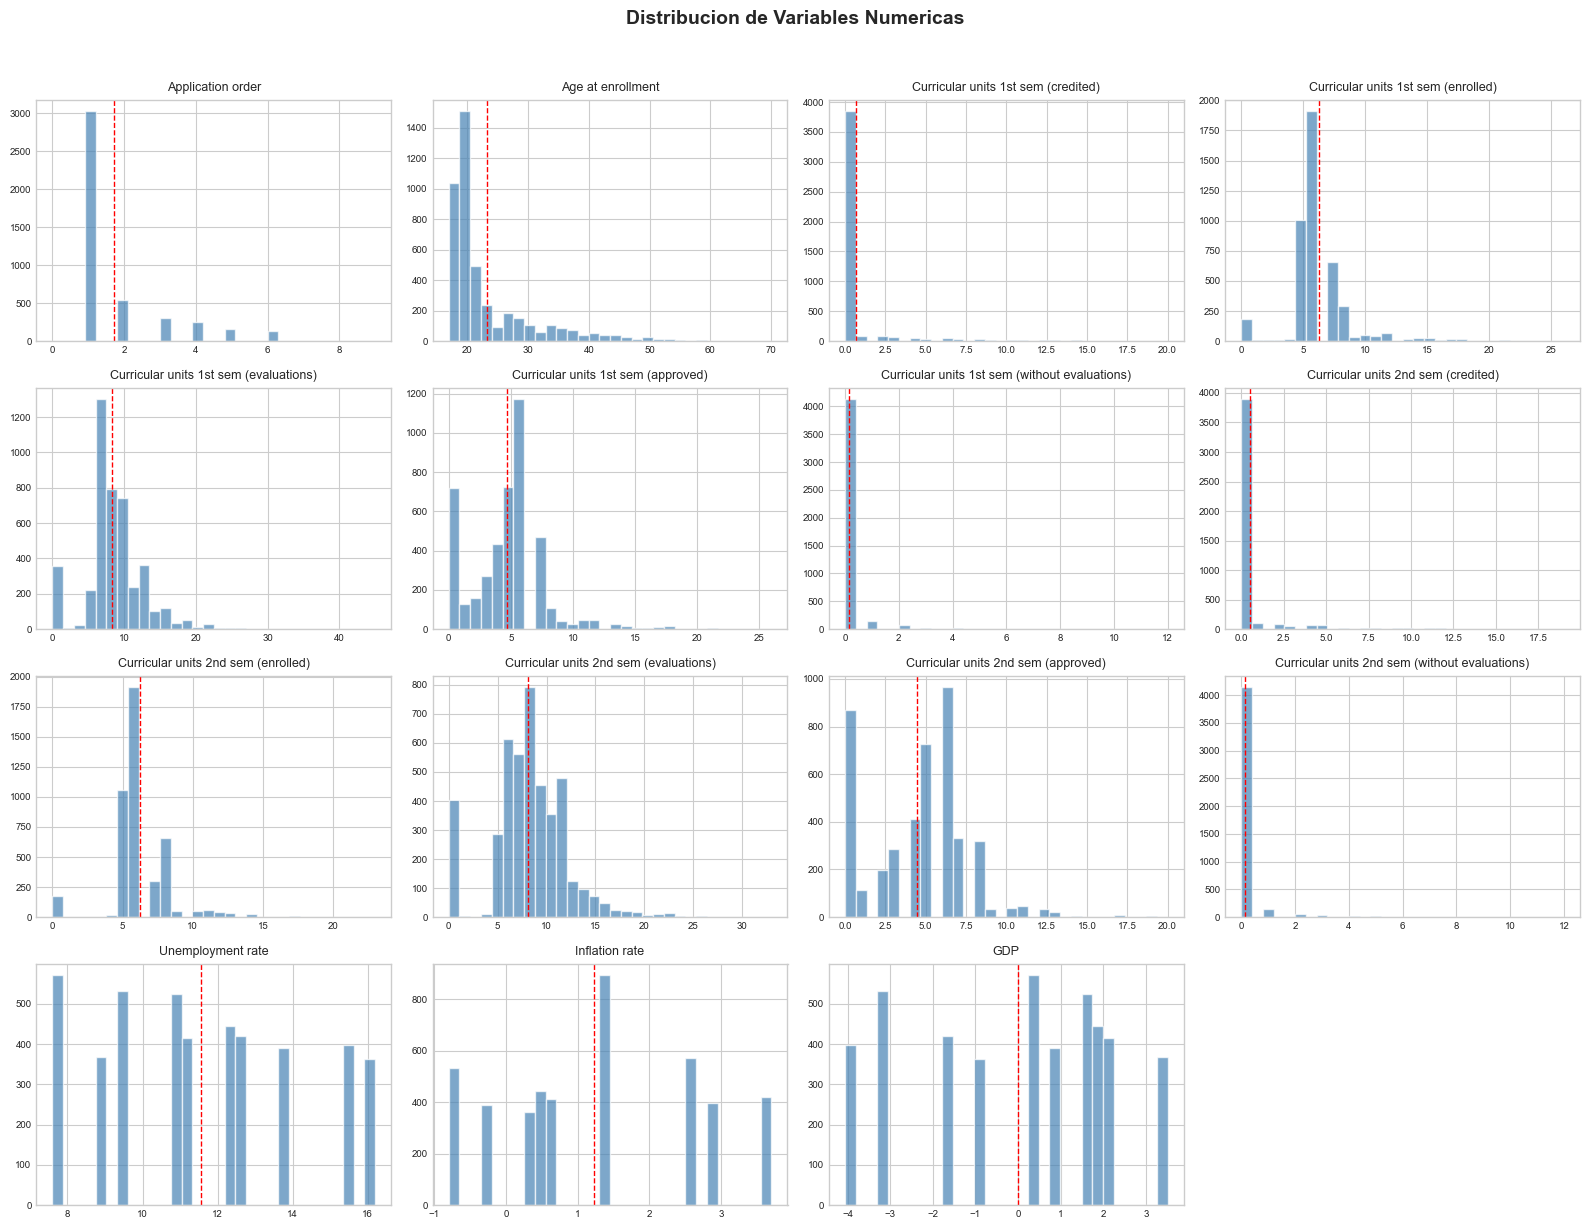

In [10]:
# Histogramas de variables numericas
num_cols_to_plot = [col for col in real_numerical_cols if col != target_col]
n_cols = 4
n_rows = (len(num_cols_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(num_cols_to_plot):
    ax = axes[idx]
    df[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='white', alpha=0.7)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=7)
    
    # Agregar linea de media
    mean_val = df[col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Media: {mean_val:.2f}')

# Ocultar ejes vacios
for idx in range(len(num_cols_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribucion de Variables Numericas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


### 3.2 Boxplots de Variables Numericas


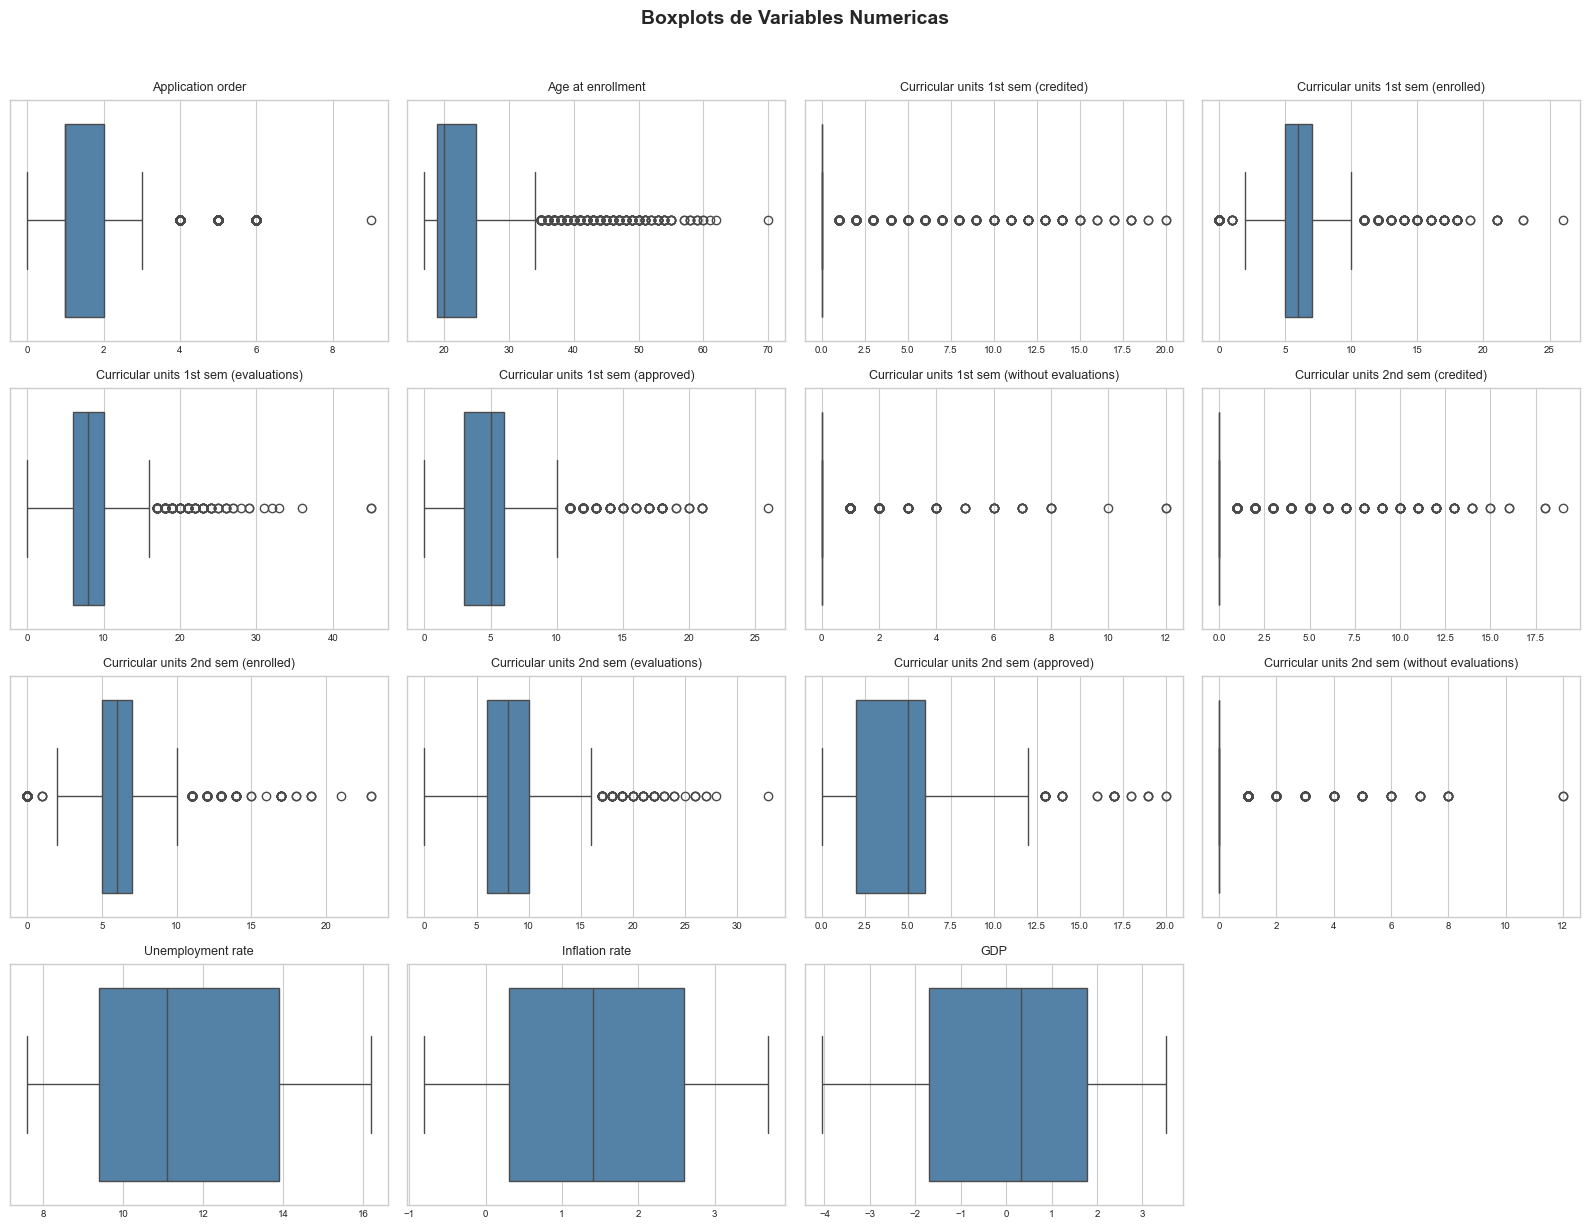

In [11]:
# Boxplots de variables numericas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(num_cols_to_plot):
    ax = axes[idx]
    sns.boxplot(data=df, x=col, ax=ax, color='steelblue')
    ax.set_title(col, fontsize=9)
    ax.set_xlabel('')
    ax.tick_params(axis='both', labelsize=7)

# Ocultar ejes vacios
for idx in range(len(num_cols_to_plot), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Boxplots de Variables Numericas', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 4. Analisis de Variables Categoricas

### 4.1 Distribucion de la Variable Target


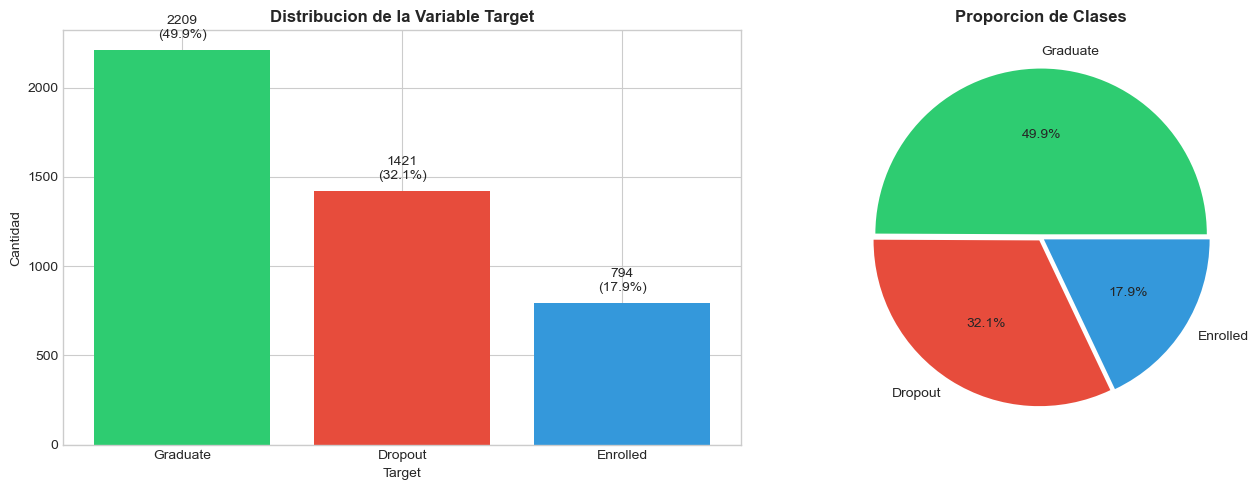


Resumen de la Variable Target:
----------------------------------------
  Graduate: 2209 estudiantes (49.93%)
  Dropout: 1421 estudiantes (32.12%)
  Enrolled: 794 estudiantes (17.95%)


In [12]:
# Analisis de la variable Target
if target_col:
    target_counts = df[target_col].value_counts()
    target_percentages = df[target_col].value_counts(normalize=True) * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Grafico de barras
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    bars = axes[0].bar(target_counts.index, target_counts.values, color=colors[:len(target_counts)])
    axes[0].set_title('Distribucion de la Variable Target', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Target')
    axes[0].set_ylabel('Cantidad')
    
    # Agregar etiquetas en las barras
    for bar, count, pct in zip(bars, target_counts.values, target_percentages.values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10)
    
    # Grafico de pastel
    axes[1].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%', 
                colors=colors[:len(target_counts)], explode=[0.02]*len(target_counts))
    axes[1].set_title('Proporcion de Clases', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen
    print("\nResumen de la Variable Target:")
    print("-" * 40)
    for label, count, pct in zip(target_counts.index, target_counts.values, target_percentages.values):
        print(f"  {label}: {count} estudiantes ({pct:.2f}%)")
else:
    print("No se encontro la variable Target en el dataset")


### 4.2 Distribucion Variables Categoricas

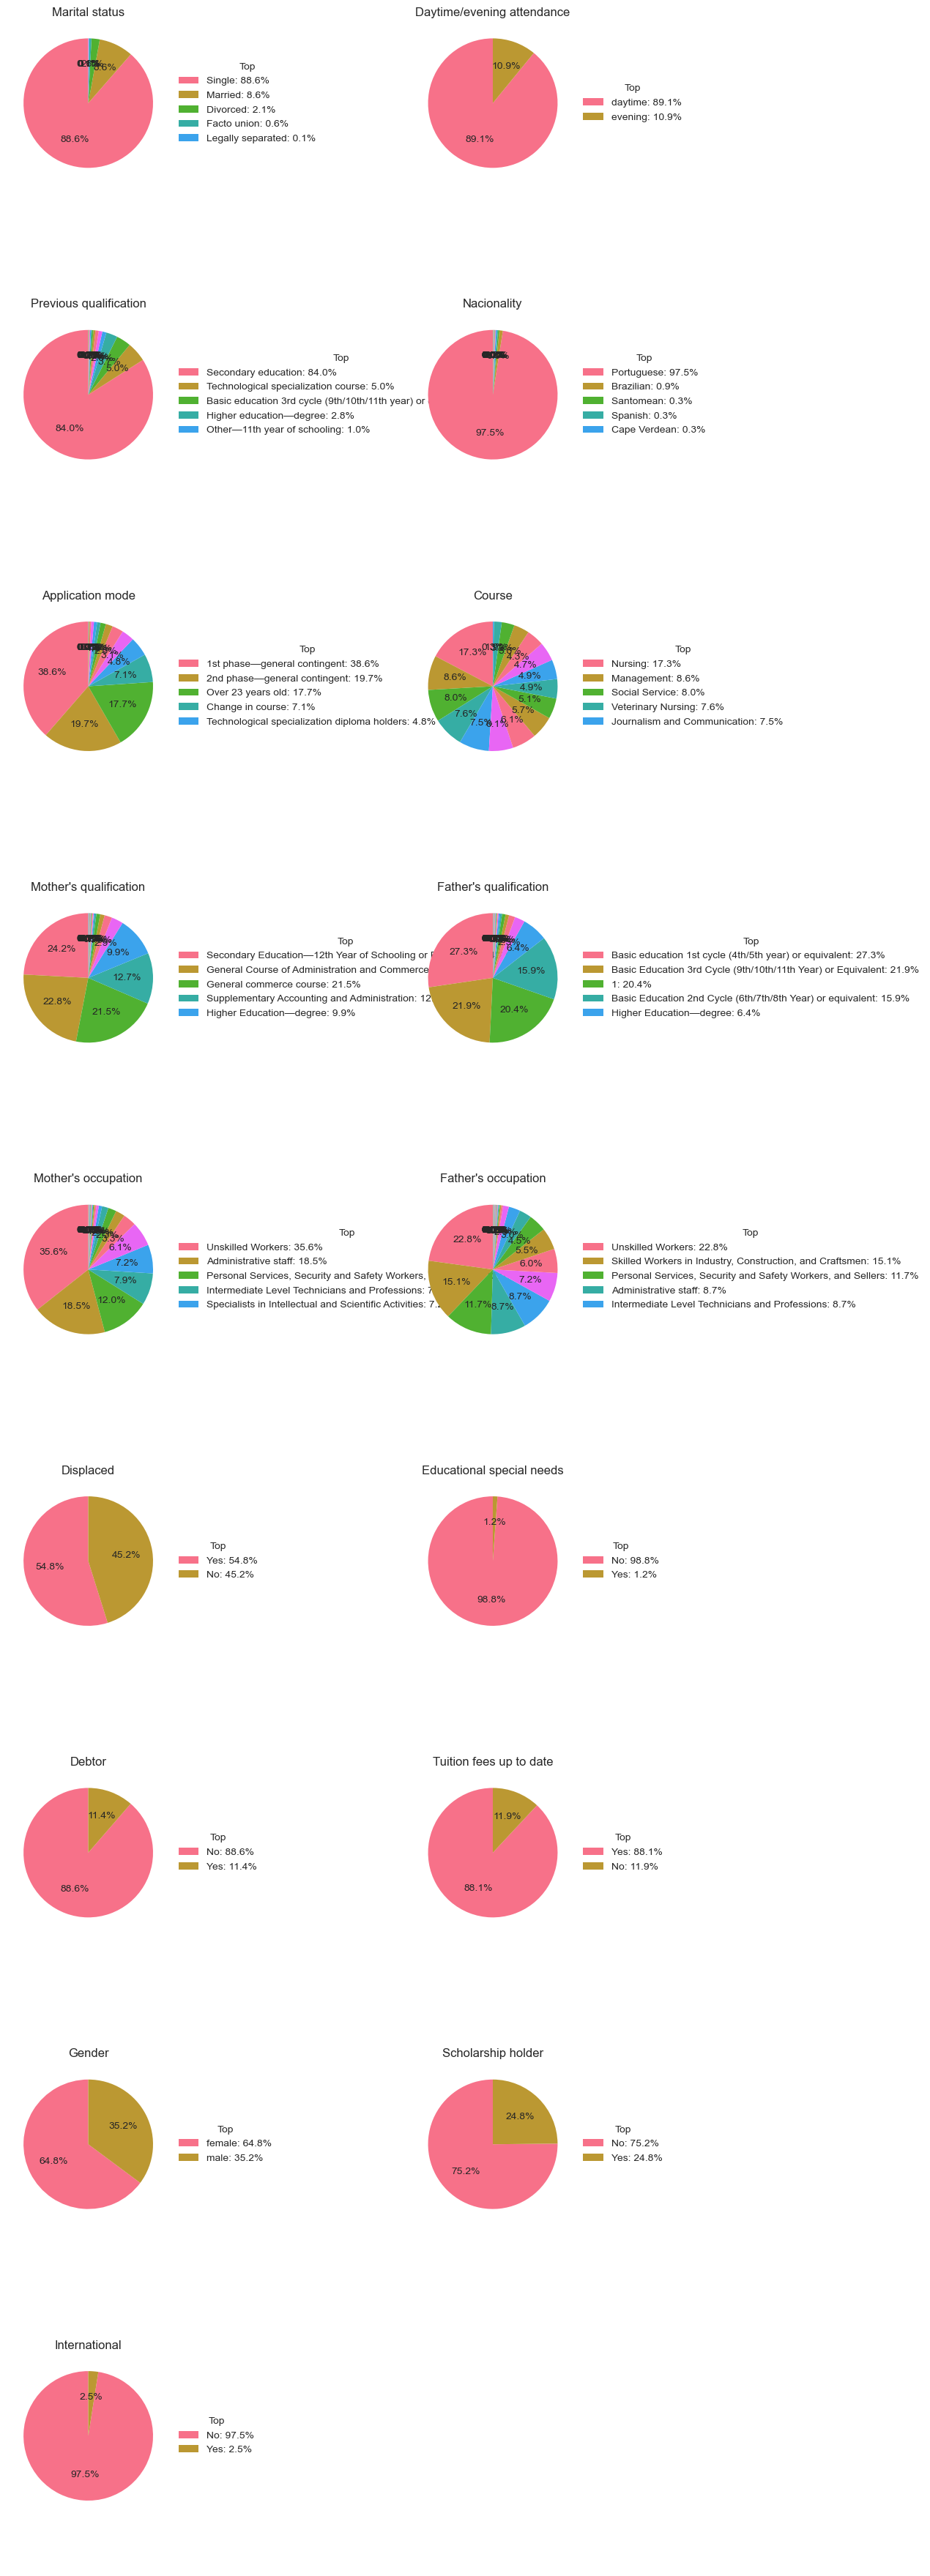

In [22]:
import math

def analyze_encoded_categoricals(df, cat_cols, mappings=None, top_n=10, plot=True, ncols=3):
    """
    df: DataFrame
    cat_cols: list of encoded categorical columns
    mappings: dict {col: {code: label}} optional
    """
    n = len(cat_cols)
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()   

    for i, col in enumerate(cat_cols):
        s = df[col]
        counts = s.value_counts(dropna=False)
        perc = counts / counts.sum() * 100

        # Build top3 legend labels with mapping
        top3 = perc.head(5)
        legend_labels = []
        for code, pct in top3.items():
            label = mappings.get(col, {}).get(code, str(code)) if mappings else str(code)
            legend_labels.append(f"{label}: {pct:.1f}%")

        # Pie chart
        axes[i].pie(
            counts.values,
            labels=None,           # keep clean
            autopct="%1.1f%%",
            startangle=90
        )
        axes[i].set_title(col)

        # Legend on the right
        axes[i].legend(
            legend_labels,
            title="Top",
            loc="center left",
            bbox_to_anchor=(1.0, 0.5)
        )

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

analyze_encoded_categoricals(df, real_categorical_cols, mappings=mapping, plot=True, ncols=2)

## 5. Analisis de Correlaciones

### 5.1 Matriz de Correlacion


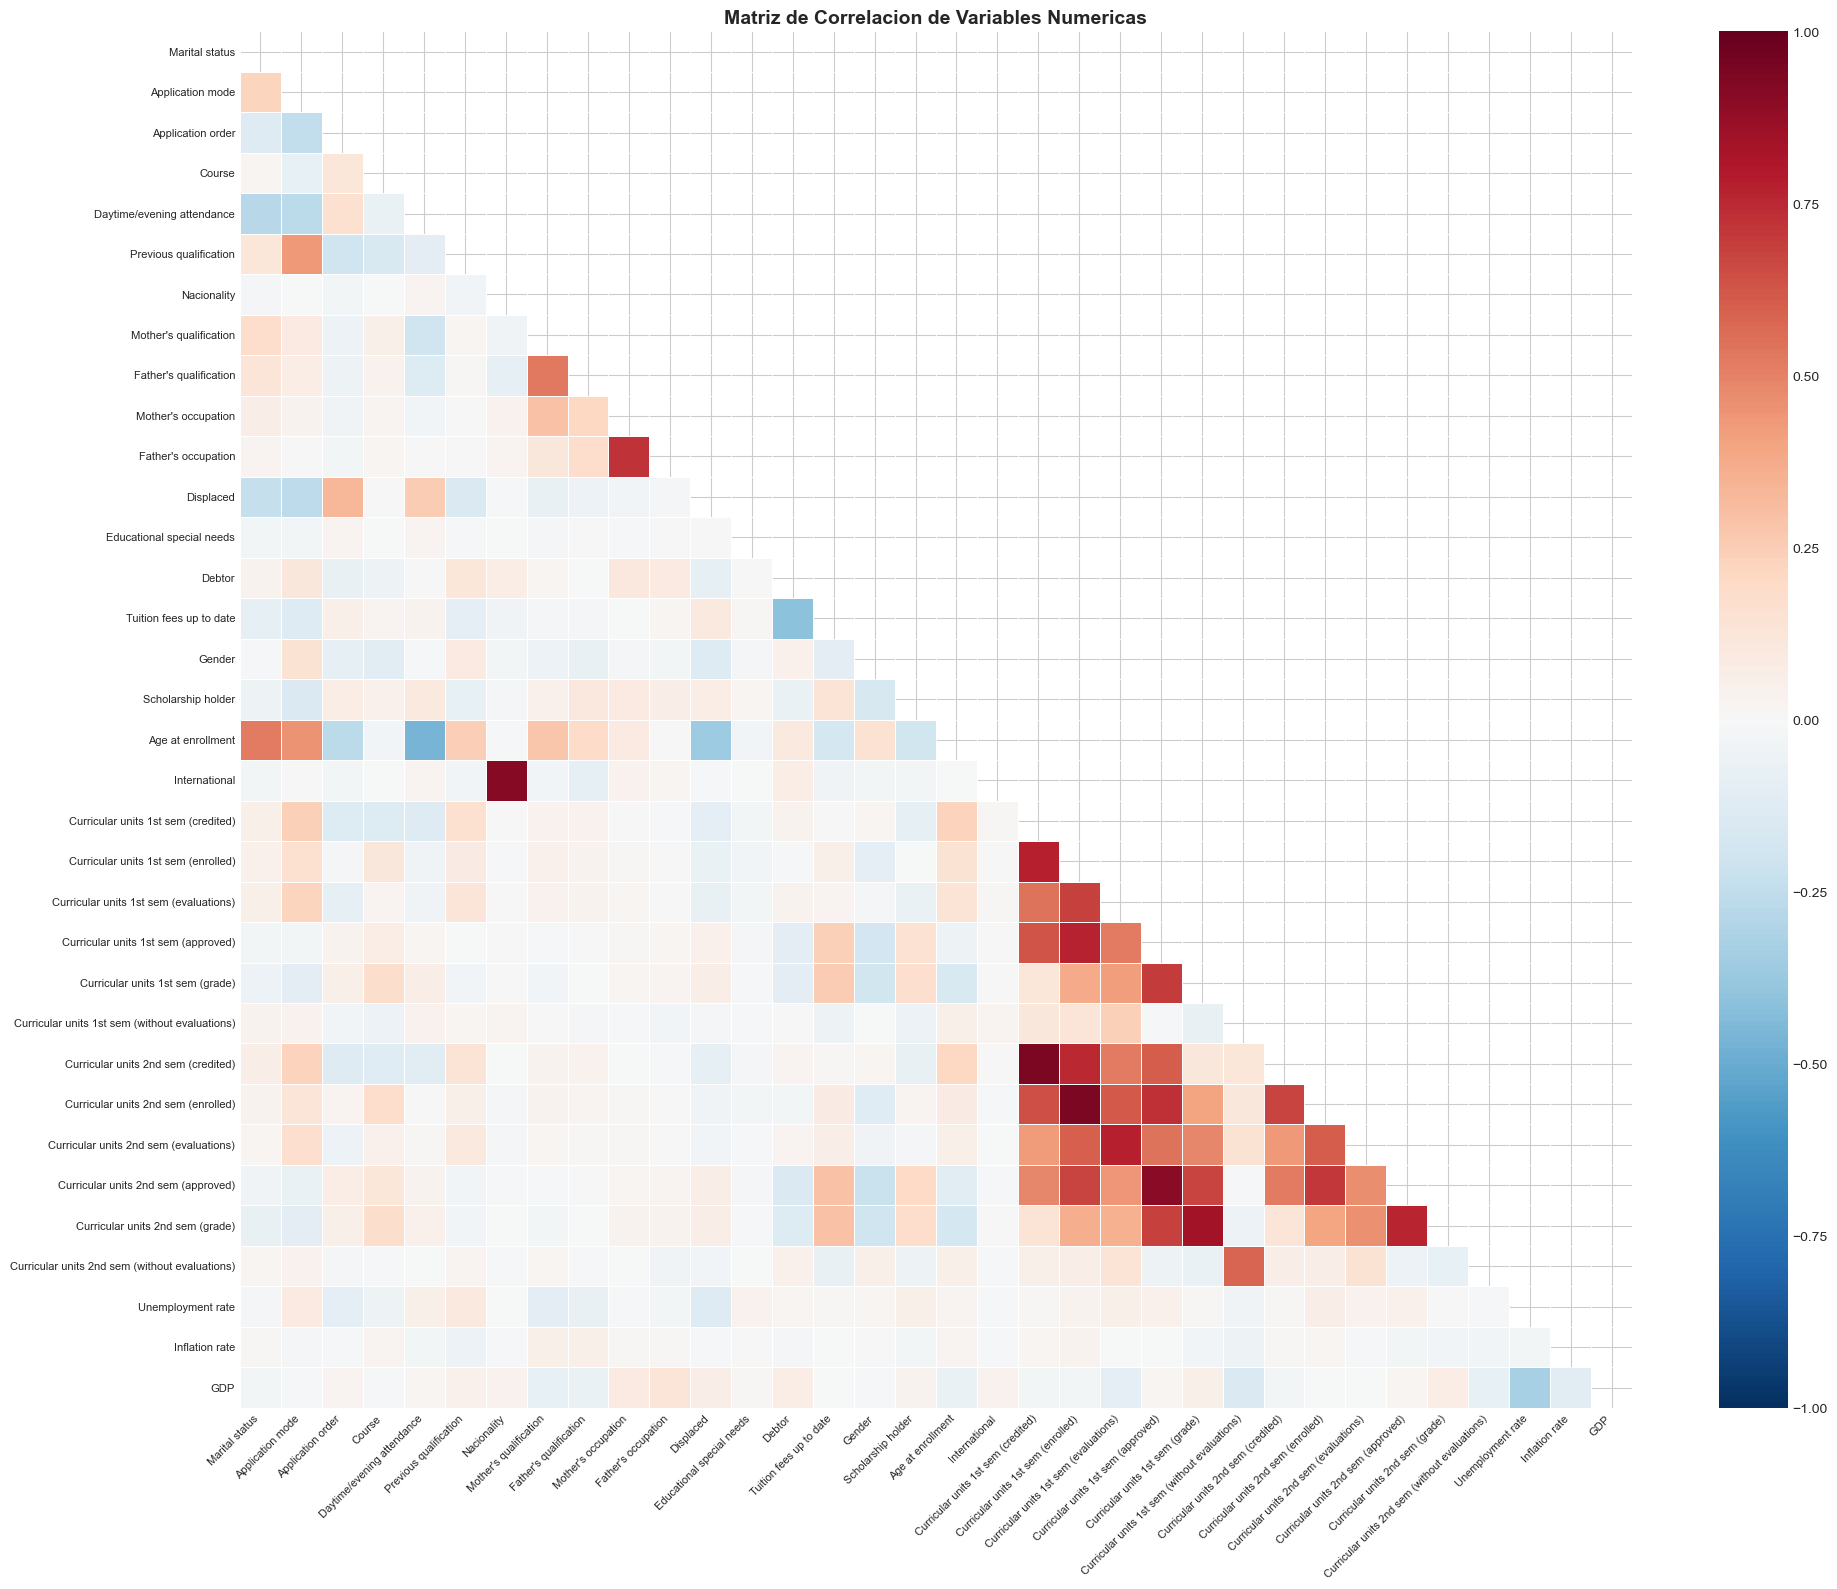

In [14]:
# Matriz de correlacion
correlation_matrix = df[numerical_cols].corr()

# Heatmap de correlaciones
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu_r', 
            center=0, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matriz de Correlacion de Variables Numericas', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


### 5.2 Top Correlaciones


In [15]:
# Extraer las correlaciones mas fuertes (positivas y negativas)
def get_top_correlations(corr_matrix, n=15, only_strong=False):
    """Obtiene las n correlaciones mas fuertes del dataset"""
    # Obtener solo el triangulo superior para evitar duplicados
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Convertir a formato largo y ordenar por valor absoluto
    correlations = upper_triangle.unstack().dropna()
    correlations = correlations.reset_index()
    correlations.columns = ['Variable 1', 'Variable 2', 'Correlacion']
    correlations['Abs_Correlacion'] = correlations['Correlacion'].abs()
    correlations = correlations.sort_values('Abs_Correlacion', ascending=False).head(n)

    if only_strong:
        correlations = correlations[correlations['Abs_Correlacion'] > 0.7]
    
    return correlations[['Variable 1', 'Variable 2', 'Correlacion']]

top_corr = get_top_correlations(correlation_matrix, n=15, only_strong=True)

print("=" * 80)
print("TOP CORRELACIONES MAS FUERTES (>0.7 en coeficiente de Pearson)")
print("=" * 80)
display(top_corr.style.background_gradient(subset=['Correlacion'], cmap='RdBu_r', vmin=-1, vmax=1))


TOP CORRELACIONES MAS FUERTES (>0.7 en coeficiente de Pearson)


,Variable 1,Variable 2,Correlacion
319,Curricular units 2nd sem (credited),Curricular units 1st sem (credited),0.944811
345,Curricular units 2nd sem (enrolled),Curricular units 1st sem (enrolled),0.942627
159,International,Nacionality,0.911724
400,Curricular units 2nd sem (approved),Curricular units 1st sem (approved),0.904002
429,Curricular units 2nd sem (grade),Curricular units 1st sem (grade),0.837170
372,Curricular units 2nd sem (evaluations),Curricular units 1st sem (evaluations),0.778863
209,Curricular units 1st sem (enrolled),Curricular units 1st sem (credited),0.774344
251,Curricular units 1st sem (approved),Curricular units 1st sem (enrolled),0.769083
434,Curricular units 2nd sem (grade),Curricular units 2nd sem (approved),0.760804
320,Curricular units 2nd sem (credited),Curricular units 1st sem (enrolled),0.753747


## 6. Analisis Bivariado (Variables vs Target)

### 6.1 Variables Numericas vs Target


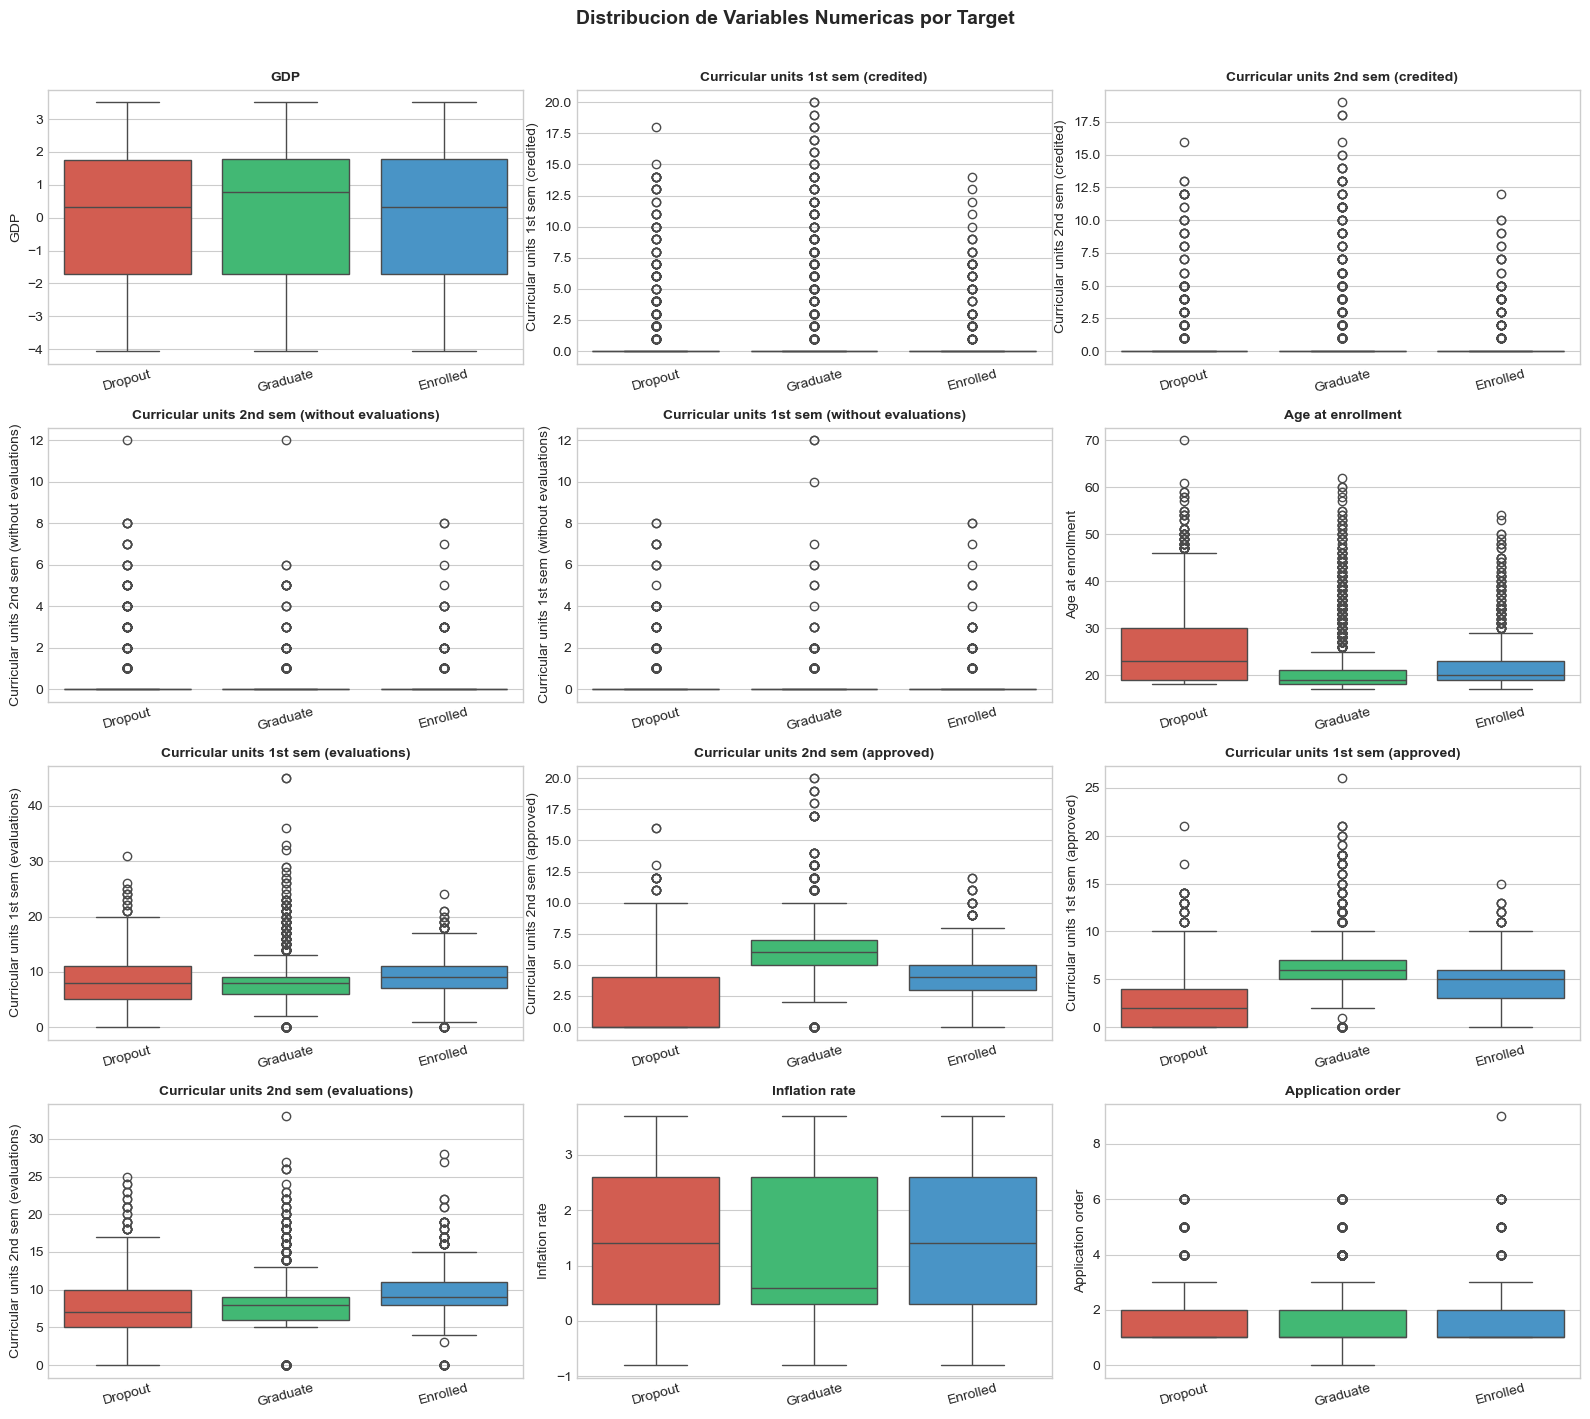

In [16]:
# Boxplots de variables numericas agrupadas por Target
if target_col:
    # Seleccionar variables mas relevantes (con mayor varianza normalizada)
    variances = df[num_cols_to_plot].var() / df[num_cols_to_plot].mean().abs()
    top_vars = variances.nlargest(12).index.tolist()
    
    n_cols_plot = 3
    n_rows_plot = 4
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(16, 14))
    axes = axes.flatten()
    
    colors = {'Dropout': '#e74c3c', 'Graduate': '#2ecc71', 'Enrolled': '#3498db'}
    
    for idx, col in enumerate(top_vars):
        ax = axes[idx]
        sns.boxplot(data=df, x=target_col, y=col, ax=ax, palette=colors)
        ax.set_title(f'{col}', fontsize=10, fontweight='bold')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=15)
    
    # Ocultar ejes vacios
    for idx in range(len(top_vars), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Distribucion de Variables Numericas por Target', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("Variable Target no encontrada")


### 6.2 Estadisticas por Grupo de Target


In [17]:
# Estadisticas descriptivas agrupadas por Target
if target_col:
    grouped_stats = df.groupby(target_col)[numerical_cols].agg(['mean', 'std']).round(2)
    
    print("=" * 80)
    print("ESTADISTICAS DESCRIPTIVAS POR GRUPO DE TARGET")
    print("=" * 80)
    
    # Mostrar para las variables mas relevantes
    for col in top_vars[:6]:
        print(f"\n{col}:")
        print("-" * 40)
        for target_val in df[target_col].unique():
            mean = df[df[target_col] == target_val][col].mean()
            std = df[df[target_col] == target_val][col].std()
            print(f"  {target_val}: Media = {mean:.2f}, Std = {std:.2f}")


ESTADISTICAS DESCRIPTIVAS POR GRUPO DE TARGET

GDP:
----------------------------------------
  Dropout: Media = -0.15, Std = 2.25
  Graduate: Media = 0.08, Std = 2.26
  Enrolled: Media = 0.05, Std = 2.32

Curricular units 1st sem (credited):
----------------------------------------
  Dropout: Media = 0.61, Std = 2.10
  Graduate: Media = 0.85, Std = 2.69
  Enrolled: Media = 0.51, Std = 1.72

Curricular units 2nd sem (credited):
----------------------------------------
  Dropout: Media = 0.45, Std = 1.68
  Graduate: Media = 0.67, Std = 2.21
  Enrolled: Media = 0.36, Std = 1.33

Curricular units 2nd sem (without evaluations):
----------------------------------------
  Dropout: Media = 0.24, Std = 0.99
  Graduate: Media = 0.08, Std = 0.52
  Enrolled: Media = 0.19, Std = 0.78

Curricular units 1st sem (without evaluations):
----------------------------------------
  Dropout: Media = 0.19, Std = 0.79
  Graduate: Media = 0.09, Std = 0.59
  Enrolled: Media = 0.18, Std = 0.74

Age at enrollment

## 7. Deteccion de Outliers

### 7.1 Metodo IQR (Rango Intercuartilico)


In [18]:
# Deteccion de outliers usando el metodo IQR
def detect_outliers_iqr(df, columns):
    """
    Detecta outliers usando el metodo IQR (Rango Intercuartilico).
    
    Outliers son valores que caen fuera del rango [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
    """
    outlier_summary = []
    
    for col in columns:

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        n_outliers = len(outliers)
        pct_outliers = (n_outliers / len(df)) * 100
        
        outlier_summary.append({
            'Variable': col,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Limite Inferior': lower_bound,
            'Limite Superior': upper_bound,
            'N Outliers': n_outliers,
            '% Outliers': pct_outliers
        })
    
    return pd.DataFrame(outlier_summary)


real_numerical_cols = [col for col in df.columns if col not in categorical_cols] # from diccionario.csv
# Calcular outliers
outlier_df = detect_outliers_iqr(df, num_cols_to_plot)
outlier_df = outlier_df.sort_values('N Outliers', ascending=False)

print("=" * 80)
print("RESUMEN DE OUTLIERS POR VARIABLE (Metodo IQR)")
print("=" * 80)
display(outlier_df.style.background_gradient(subset=['N Outliers', '% Outliers'], cmap='Reds'))


RESUMEN DE OUTLIERS POR VARIABLE (Metodo IQR)


,Variable,Q1,Q3,IQR,Limite Inferior,Limite Superior,N Outliers,% Outliers
2,Curricular units 1st sem (credited),0.000000,0.000000,0.000000,0.000000,0.000000,577,13.042495
0,Application order,1.000000,2.000000,1.000000,-0.500000,3.500000,541,12.228752
7,Curricular units 2nd sem (credited),0.000000,0.000000,0.000000,0.000000,0.000000,530,11.980108
1,Age at enrollment,19.000000,25.000000,6.000000,10.000000,34.000000,441,9.968354
3,Curricular units 1st sem (enrolled),5.000000,7.000000,2.000000,2.000000,10.000000,424,9.584087
8,Curricular units 2nd sem (enrolled),5.000000,7.000000,2.000000,2.000000,10.000000,369,8.340868
6,Curricular units 1st sem (without evaluations),0.000000,0.000000,0.000000,0.000000,0.000000,294,6.645570
11,Curricular units 2nd sem (without evaluations),0.000000,0.000000,0.000000,0.000000,0.000000,282,6.374322
5,Curricular units 1st sem (approved),3.000000,6.000000,3.000000,-1.500000,10.500000,180,4.068716
4,Curricular units 1st sem (evaluations),6.000000,10.000000,4.000000,0.000000,16.000000,158,3.571429


### 7.2 Visualizacion de Variables con Mas Outliers


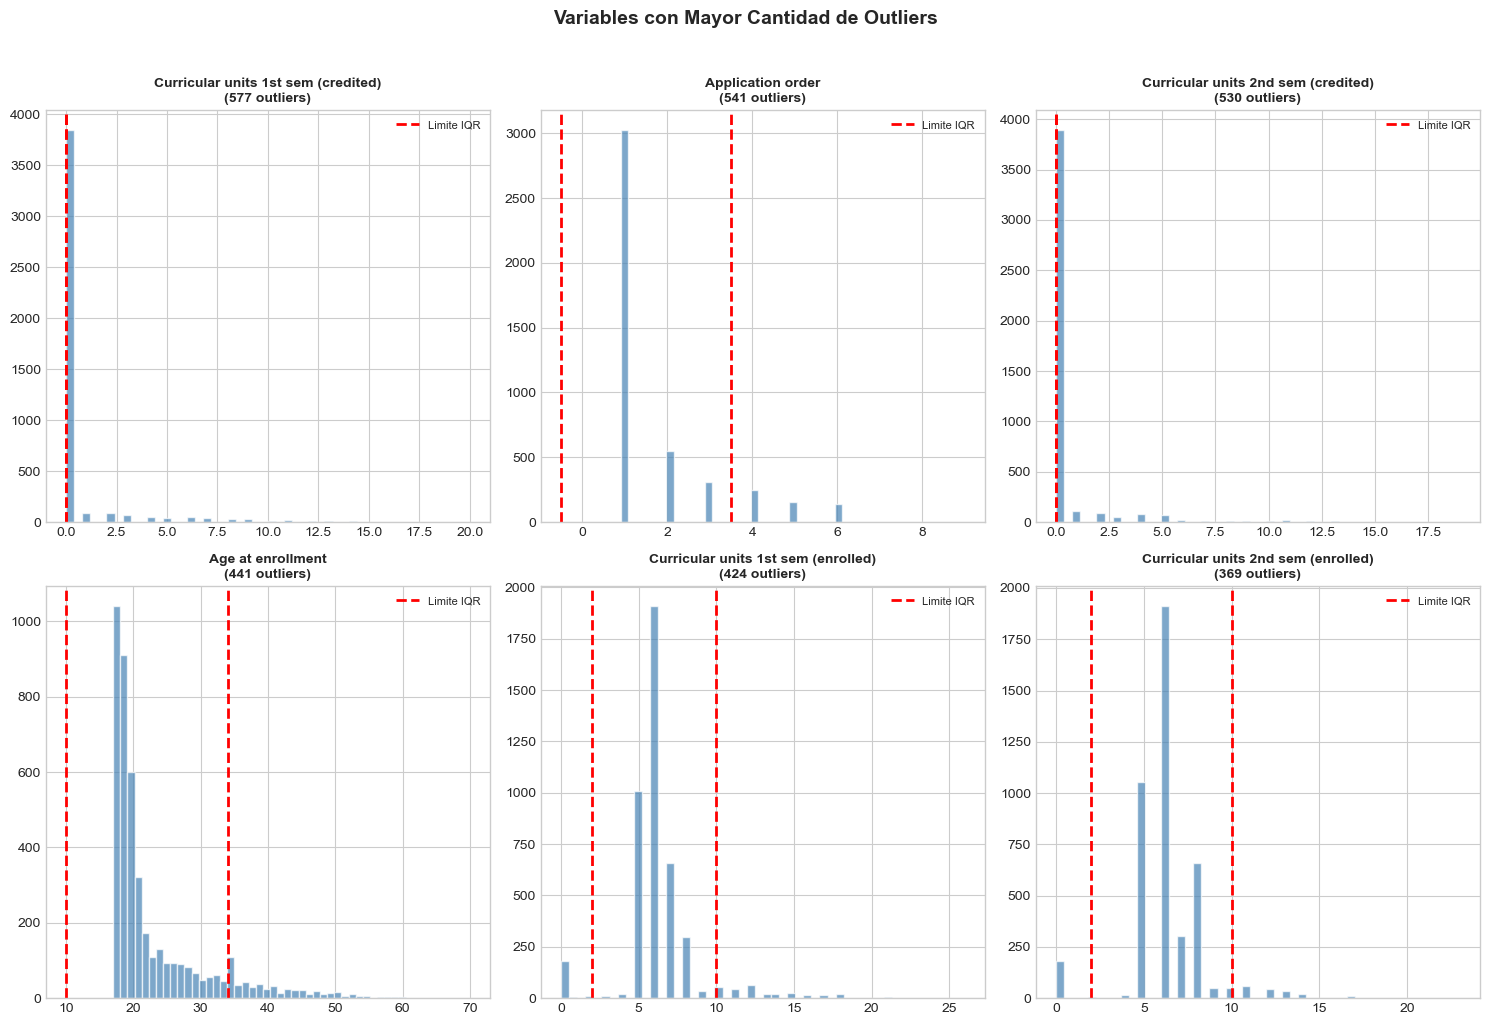

In [19]:
# Visualizar las variables con mas outliers
top_outlier_vars = outlier_df.nlargest(6, 'N Outliers')['Variable'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(top_outlier_vars):
    ax = axes[idx]
    
    # Calcular limites IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Histograma
    ax.hist(df[col], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(lower_bound, color='red', linestyle='--', linewidth=2, label='Limite IQR')
    ax.axvline(upper_bound, color='red', linestyle='--', linewidth=2)
    
    n_outliers = outlier_df[outlier_df['Variable'] == col]['N Outliers'].values[0]
    ax.set_title(f'{col}\n({n_outliers} outliers)', fontsize=10, fontweight='bold')
    ax.legend(fontsize=8)

plt.suptitle('Variables con Mayor Cantidad de Outliers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Resumen

In [35]:
print(f"\n1. DATASET:")
print(f"   - Dimensiones: {df.shape[0]} filas x {df.shape[1]} columnas")
print(f"   - Variables numericas: {len(numerical_cols)}")
print(f"   - Variables categoricas: {len(categorical_cols)}")

print(f"\n2. CALIDAD DE DATOS:")
print(f"   - Valores nulos: {df.isnull().sum().sum()} ({df.isnull().sum().sum()/df.size*100:.2f}%)")
print(f"   - Filas duplicadas: {df.duplicated().sum()}")

if target_col:
    print(f"\n3. VARIABLE TARGET ({target_col}):")
    for label, count, pct in zip(target_counts.index, target_counts.values, target_percentages.values):
        print(f"   - {label}: {count} ({pct:.1f}%)")

print(f"\n4. OUTLIERS:")
print(f"   - Variables con outliers: {(outlier_df['N Outliers'] > 0).sum()}")
print(f"   - Destacados")
for idx, row in outlier_df.head(3).iterrows():
    print(f"        - {row['Variable']} ({row['N Outliers']:.0f} outliers)")

print(f"\n5. CORRELACIONES DESTACADAS:")
for idx, row in top_corr.head(5).iterrows():
    print(f"   - {row['Variable 1']} <-> {row['Variable 2']}: {row['Correlacion']:.3f}")



1. DATASET:
   - Dimensiones: 4424 filas x 35 columnas
   - Variables numericas: 34
   - Variables categoricas: 1

2. CALIDAD DE DATOS:
   - Valores nulos: 0 (0.00%)
   - Filas duplicadas: 0

3. VARIABLE TARGET (Target):
   - Graduate: 2209 (49.9%)
   - Dropout: 1421 (32.1%)
   - Enrolled: 794 (17.9%)

4. OUTLIERS:
   - Variables con outliers: 12
   - Destacados
        - Curricular units 1st sem (credited) (577 outliers)
        - Application order (541 outliers)
        - Curricular units 2nd sem (credited) (530 outliers)

5. CORRELACIONES DESTACADAS:
   - Curricular units 2nd sem (credited) <-> Curricular units 1st sem (credited): 0.945
   - Curricular units 2nd sem (enrolled) <-> Curricular units 1st sem (enrolled): 0.943
   - International <-> Nacionality: 0.912
   - Curricular units 2nd sem (approved) <-> Curricular units 1st sem (approved): 0.904
   - Curricular units 2nd sem (grade) <-> Curricular units 1st sem (grade): 0.837
